In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from RandomForestForTimeSeriesRegressor import RandomForestForTimeSeriesRegressor, BLOCK_TYPES

In [2]:
dataset = pd.read_csv('yahoo_dataset_gspc.csv')

In [3]:
dataset = dataset.dropna()
dataset

,Date,Ticker,Open,High,Low,Close,Adj_close,Volume
0,3 dic 2024,%5EGSPC,6042.97,6052.07,6033.39,6049.88,6049.88,4095000000
1,2 dic 2024,%5EGSPC,6040.11,6053.58,6035.33,6047.15,6047.15,4412470000
2,29 nov 2024,%5EGSPC,6003.98,6044.17,6003.98,6032.38,6032.38,2444420000
3,27 nov 2024,%5EGSPC,6014.11,6020.16,5984.87,5998.74,5998.74,3363340000
4,26 nov 2024,%5EGSPC,6000.03,6025.42,5992.27,6021.63,6021.63,3835170000
...,...,...,...,...,...,...,...,...
13847,8 ene 1970,%5EGSPC,0.00,93.47,91.99,92.68,92.68,10670000
13848,7 ene 1970,%5EGSPC,0.00,93.38,91.93,92.63,92.63,10010000
13849,6 ene 1970,%5EGSPC,0.00,93.81,92.13,92.82,92.82,11460000
13850,5 ene 1970,%5EGSPC,0.00,94.25,92.53,93.46,93.46,11490000


In [4]:
from dateutil import parser

# Diccionario para traducir meses en español a inglés
MESES_ESP = {
    "ene": "Jan", "feb": "Feb", "mar": "Mar", "abr": "Apr", "may": "May", "jun": "Jun",
    "jul": "Jul", "ago": "Aug", "sep": "Sep", "oct": "Oct", "nov": "Nov", "dic": "Dec"
}

def corregir_fecha(fecha_str):
    try:
        partes = fecha_str.split()
        if len(partes) == 3:  # Asegurar que tiene día, mes y año
            dia, mes, anio = partes
            mes = MESES_ESP.get(mes.lower(), mes)  # Traducir mes al inglés
            fecha_corregida = f"{dia} {mes} {anio}"
            fecha_dt = parser.parse(fecha_corregida, dayfirst=True)  # Convertir a datetime
            return fecha_dt.strftime("%Y-%m-%d")  # Devolver en formato legible
    except Exception as e:
        print(f"Error con la fecha: {fecha_str} - {e}")
        return None  # Retorna None si hay un error

def actualizar_fecha(df, columna):
    df[columna] = df[columna].apply(lambda x: corregir_fecha(x) if pd.notna(x) else None)
    return df

dataset = actualizar_fecha(dataset, "Date")
dataset = dataset.sort_values("Date")
dataset

,Date,Ticker,Open,High,Low,Close,Adj_close,Volume
13851,1970-01-02,%5EGSPC,0.00,93.54,91.79,93.00,93.00,8050000
13850,1970-01-05,%5EGSPC,0.00,94.25,92.53,93.46,93.46,11490000
13849,1970-01-06,%5EGSPC,0.00,93.81,92.13,92.82,92.82,11460000
13848,1970-01-07,%5EGSPC,0.00,93.38,91.93,92.63,92.63,10010000
13847,1970-01-08,%5EGSPC,0.00,93.47,91.99,92.68,92.68,10670000
...,...,...,...,...,...,...,...,...
4,2024-11-26,%5EGSPC,6000.03,6025.42,5992.27,6021.63,6021.63,3835170000
3,2024-11-27,%5EGSPC,6014.11,6020.16,5984.87,5998.74,5998.74,3363340000
2,2024-11-29,%5EGSPC,6003.98,6044.17,6003.98,6032.38,6032.38,2444420000
1,2024-12-02,%5EGSPC,6040.11,6053.58,6035.33,6047.15,6047.15,4412470000


In [5]:
def calculateFields(dataset):
    if 'Date' not in dataset:
        dataset['Date'] = dataset['date']
        dataset = dataset.drop(columns=["date"])
    if 'Adj Close' in dataset:
        dataset = dataset.drop(columns=['Adj Close'])
    if 'Adj Close' in dataset:
        dataset = dataset.drop(columns=['Adj_close'])
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset['DateOrdinal'] = dataset['Date'].map(dt.datetime.toordinal)
    dataset['average_price'] = dataset[['Low', 'High']].mean(axis=1)
    dataset = dataset.drop(columns=["Volume", "Close", "Open", "Low", "High"])
    dataset['DayOfWeek'] = dataset['Date'].dt.dayofweek
    dataset['Month'] = dataset['Date'].dt.month
    dataset['Year'] = dataset['Date'].dt.year
    dataset['DayOfYear'] = dataset['Date'].dt.dayofyear
    dataset['WeekOfYear'] = dataset['Date'].dt.isocalendar().week

    dataset['is_start_of_month'] = (dataset['Date'].dt.day == 1).astype(int)
    dataset['is_end_of_month'] = (dataset['Date'] == dataset['Date'] + pd.offsets.MonthEnd(0)).astype(int)
    dataset['quarter'] = dataset['Date'].dt.quarter
    def get_season(month):
        if month in [12, 1, 2]:
            return 0#'winter'
        elif month in [3, 4, 5]:
            return 1#'spring'
        elif month in [6, 7, 8]:
            return 2#'summer'
        else:
            return 3#'autumn'
    dataset['season'] = dataset['Month'].apply(get_season)
    dataset['SerieNumber'] = (dataset['Date'] - dataset['Date'].min()).dt.days + 1


    days_ago = 30

    #dataset["price_30_days_ago"] = dataset["average_price"].shift(days_ago)
    #dataset["price_180_days_ago"] = dataset["average_price"].shift(180)
    #dataset["price_365_days_ago"] = dataset["average_price"].shift(365)


    dataset = dataset.dropna().reset_index(drop=True)
    if 'Symbol' in dataset:
        dataset['Symbol'] = pd.factorize(dataset.Symbol)[0]
    else:
        dataset['Symbol'] = pd.factorize(dataset.Ticker)[0]
        dataset = dataset.drop(columns=['Ticker'])

    return dataset

calculatedFields = ["DateOrdinal", "DayOfWeek", "Month", "Year", "DayOfYear", "WeekOfYear", "is_start_of_month", "is_end_of_month", "quarter",
                    "season", "SerieNumber"]  #, "price_30_days_ago", "price_180_days_ago", "price_365_days_ago"]  #, "Symbol"]
fieldsPrice = ["average_price"]


dataset = calculateFields(dataset)

In [6]:
from datetime import datetime

pivote_date = datetime.strptime("01/01/2018", "%d/%m/%Y")
max_train_day = datetime.strptime("31/12/2018", "%d/%m/%Y") #pivote_date + pd.DateOffset(days=1825)
max_day = datetime.strptime("31/12/2020", "%d/%m/%Y")
max_test_1 = datetime.strptime("30/06/2019", "%d/%m/%Y")
max_test_2 = datetime.strptime("31/12/2019", "%d/%m/%Y")
max_test_3 = datetime.strptime("31/03/2019", "%d/%m/%Y")
trainBlock = dataset[(dataset['Date'] >= pivote_date) & (dataset['Date'] <= max_train_day)]

testBlock_6months = dataset[(dataset['Date'] > max_train_day) & (dataset['Date'] <= max_test_1)] 
testBlock_1year = dataset[(dataset['Date'] > max_train_day) & (dataset['Date'] <= max_test_2)] 
testBlock_2years = dataset[(dataset['Date'] > max_train_day) & (dataset['Date'] <= max_test_3)] 

trainBlock

,Date,Adj_close,DateOrdinal,average_price,DayOfWeek,Month,Year,DayOfYear,WeekOfYear,is_start_of_month,is_end_of_month,quarter,season,SerieNumber,Symbol
12110,2018-01-02,2695.81,736696,2689.125,1,1,2018,2,1,0,0,1,0,17533,0
12111,2018-01-03,2713.06,736697,2706.070,2,1,2018,3,1,0,0,1,0,17534,0
12112,2018-01-04,2723.99,736698,2724.180,3,1,2018,4,1,0,0,1,0,17535,0
12113,2018-01-05,2743.15,736699,2735.685,4,1,2018,5,1,0,0,1,0,17536,0
12114,2018-01-08,2747.71,736702,2743.055,0,1,2018,8,2,0,0,1,0,17539,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12356,2018-12-24,2351.10,737052,2380.720,0,12,2018,358,52,0,0,4,0,17889,0
12357,2018-12-26,2467.70,737054,2407.170,2,12,2018,360,52,0,0,4,0,17891,0
12358,2018-12-27,2488.83,737055,2443.520,3,12,2018,361,52,0,0,4,0,17892,0
12359,2018-12-28,2485.74,737056,2496.580,4,12,2018,362,52,0,0,4,0,17893,0


In [7]:
aux = trainBlock.copy()
aux = aux.drop("Date", axis=1)
X_train = aux[calculatedFields].copy()
aux = aux.drop(calculatedFields, axis=1)

Y_train = aux[fieldsPrice].copy()

aux = testBlock_6months.copy()
aux = aux.drop("Date", axis=1)
X_test = aux[calculatedFields].copy()

aux = aux.drop(calculatedFields, axis=1)
Y_test = aux[fieldsPrice].copy()

aux = testBlock_1year.copy()
aux = aux.drop("Date", axis=1)
X_test_1y = aux[calculatedFields].copy()

aux = aux.drop(calculatedFields, axis=1)
Y_test_1y = aux[fieldsPrice].copy()

aux = testBlock_2years.copy()
aux = aux.drop("Date", axis=1)
X_test_2y = aux[calculatedFields].copy()

aux = aux.drop(calculatedFields, axis=1)
Y_test_2y = aux[fieldsPrice].copy()

In [8]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

basicRFPrecision = []
basicRFPrecision_1y = []
basicRFPrecision_2y = []
for i in range(50):
    basicRF = RandomForestRegressor(n_jobs=100, n_estimators=100, max_depth=10)
    basicRF.fit(X_train, Y_train)
    y_pred = basicRF.predict(X_test)
    rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
    basicRFPrecision.append(rmse0)
    y_pred = basicRF.predict(X_test_1y)
    rmse0 = sqrt(mean_squared_error(Y_test_1y, y_pred))
    basicRFPrecision_1y.append(rmse0)
    y_pred = basicRF.predict(X_test_2y)
    rmse0 = sqrt(mean_squared_error(Y_test_2y, y_pred))
    basicRFPrecision_2y.append(rmse0)

c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Rikudo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataCon

In [10]:
# daysOfBlocks = 730
# daysOfTraining = 365
# X_train0, Y_train0, X_test0, Y_test0 = getRandomTrainTestData(dataset, daysOfBlocks, daysOfTraining)
#totalSamplesAprox = trainSamples #X_train.shape[0]
#blockSizes = [totalSamplesAprox / 100, totalSamplesAprox / 50, totalSamplesAprox / 20, totalSamplesAprox / 10, totalSamplesAprox / 5]
#for i in range(len(blockSizes)):
#    blockSizes[i] = int(blockSizes[i])
blockSizes = [5, 6, 7, 8, 9, 10, 20, 30, 50, 100, 200]  #, 300, 400] #[15, 30, 60, 150, 300]
#blockSizes = [15, 30, 60, 150, 300]


In [11]:
precisionNonOverlapping = dict()
precisionNonOverlapping_1y = dict()
precisionNonOverlapping_2y = dict()
for block_size in blockSizes:
    precisionNonOverlapping[block_size] = []
    precisionNonOverlapping_1y[block_size] = []
    precisionNonOverlapping_2y[block_size] = []
    for k in range(50):
        rfts = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=100, block_size=block_size, max_depth=10)
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        precisionNonOverlapping[block_size].append(rmse0)
        y_pred = rfts.predict(X_test_1y)
        rmse0 = sqrt(mean_squared_error(Y_test_1y, y_pred))
        precisionNonOverlapping_1y[block_size].append(rmse0)
        y_pred = rfts.predict(X_test_2y)
        rmse0 = sqrt(mean_squared_error(Y_test_2y, y_pred))
        precisionNonOverlapping_2y[block_size].append(rmse0)

In [12]:
def getGraphData(presitionDataArray):
    all_arr = [[]]
    ticksIdx = [0]
    ticksNames = ["RF"]
    idx = 0
    for blockSize in blockSizes:
        
        data0 = []
        for r in presitionDataArray[blockSize]:
            data0.append(r)

        all_arr.append(data0)
        idx += 1
        ticksIdx.append(idx)
        ticksNames.append(str(blockSize))

    return all_arr, ticksIdx, ticksNames

In [13]:
precisionMovingBlock = dict()
precisionMovingBlock_1y = dict()
precisionMovingBlock_2y = dict()
for block_size in blockSizes:
    precisionMovingBlock[block_size] = []
    precisionMovingBlock_1y[block_size] = []
    precisionMovingBlock_2y[block_size] = []
    for k in range(50):
        rfts = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=500, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[1])
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        precisionMovingBlock[block_size].append(rmse0)
        y_pred = rfts.predict(X_test_1y)
        rmse0 = sqrt(mean_squared_error(Y_test_1y, y_pred))
        precisionMovingBlock_1y[block_size].append(rmse0)
        y_pred = rfts.predict(X_test_2y)
        rmse0 = sqrt(mean_squared_error(Y_test_2y, y_pred))
        precisionMovingBlock_2y[block_size].append(rmse0)

In [14]:
precisionCircularBlock = dict()
precisionCircularBlock_1y = dict()
precisionCircularBlock_2y = dict()
for block_size in blockSizes:
    precisionCircularBlock[block_size] = []
    precisionCircularBlock_1y[block_size] = []
    precisionCircularBlock_2y[block_size] = []
    for k in range(50):
        rfts = RandomForestForTimeSeriesRegressor(n_jobs=100, n_estimators=100, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[2])
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        rmse0 = sqrt(mean_squared_error(Y_test, y_pred))
        precisionCircularBlock[block_size].append(rmse0)
        y_pred = rfts.predict(X_test_1y)
        rmse0 = sqrt(mean_squared_error(Y_test_1y, y_pred))
        precisionCircularBlock_1y[block_size].append(rmse0)
        y_pred = rfts.predict(X_test_2y)
        rmse0 = sqrt(mean_squared_error(Y_test_2y, y_pred))
        precisionCircularBlock_2y[block_size].append(rmse0)

In [15]:
rf_array = [basicRFPrecision]
rf_array_1y = [basicRFPrecision_1y]
rf_array_2y = [basicRFPrecision_2y]
for i in range(1, len(precisionNonOverlapping)):
    rf_array.append([])
    rf_array_1y.append([])
    rf_array_2y.append([])

Text(38.222222222222214, 0.5, 'RMSE')

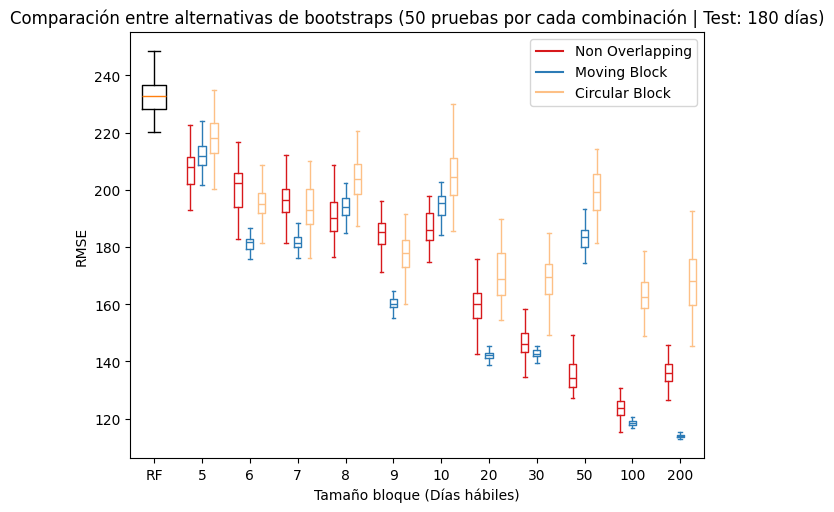

In [16]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping)
all_arr1, ticksIdx, ticksNames = getGraphData(precisionMovingBlock)
all_arr2, ticksIdx, ticksNames = getGraphData(precisionCircularBlock)

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bp0 = plt.boxplot(all_arr, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.boxplot(all_arr1, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.boxplot(all_arr2, positions=np.array(range(len(all_arr1)))*2.0+0.5, sym='', widths=0.3)
bp_1 = plt.boxplot(rf_array, positions=np.array(range(len(rf_array))), sym='', widths=1)
set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bp1, '#2C7BB6')
set_box_color(bp2, '#fdc086')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Non Overlapping')
plt.plot([], c='#2C7BB6', label='Moving Block')
plt.plot([], c='#fdc086', label='Circular Block')
plt.legend()

plt.xticks(range(0, len(ticksNames) * 2, 2), ticksNames)
# plt.xlim(-2, len(ticks)*2)
#plt.ylim(34, 55)
plt.tight_layout()
plt.title("Comparación entre alternativas de bootstraps (50 pruebas por cada combinación | Test: 180 días)")
plt.xlabel("Tamaño bloque (Días hábiles)")
plt.ylabel("RMSE")

Text(38.222222222222214, 0.5, 'RMSE')

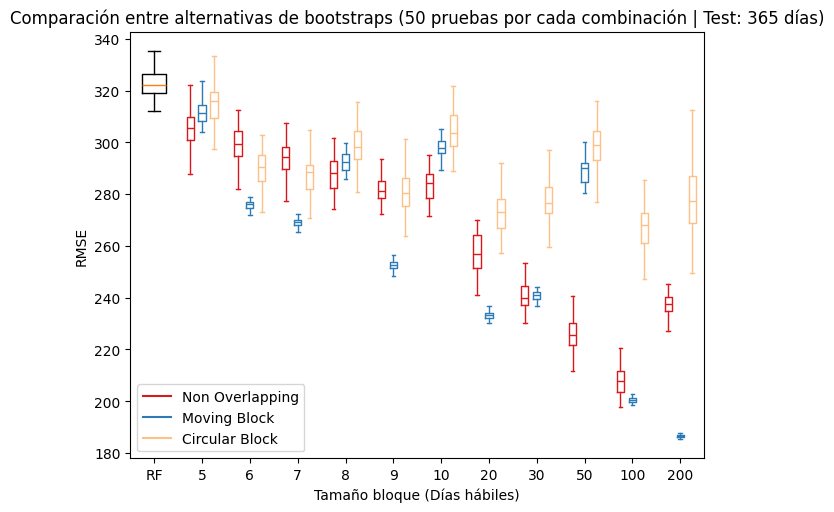

In [17]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping_1y)
all_arr1, ticksIdx, ticksNames = getGraphData(precisionMovingBlock_1y)
all_arr2, ticksIdx, ticksNames = getGraphData(precisionCircularBlock_1y)

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bp0 = plt.boxplot(all_arr, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.boxplot(all_arr1, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.boxplot(all_arr2, positions=np.array(range(len(all_arr1)))*2.0+0.5, sym='', widths=0.3)
bp_1 = plt.boxplot(rf_array_1y, positions=np.array(range(len(rf_array_1y))), sym='', widths=1)
set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bp1, '#2C7BB6')
set_box_color(bp2, '#fdc086')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Non Overlapping')
plt.plot([], c='#2C7BB6', label='Moving Block')
plt.plot([], c='#fdc086', label='Circular Block')
plt.legend()

plt.xticks(range(0, len(ticksNames) * 2, 2), ticksNames)
# plt.xlim(-2, len(ticks)*2)
#plt.ylim(34, 55)
plt.tight_layout()
plt.title("Comparación entre alternativas de bootstraps (50 pruebas por cada combinación | Test: 365 días)")
plt.xlabel("Tamaño bloque (Días hábiles)")
plt.ylabel("RMSE")

Text(38.222222222222214, 0.5, 'RMSE')

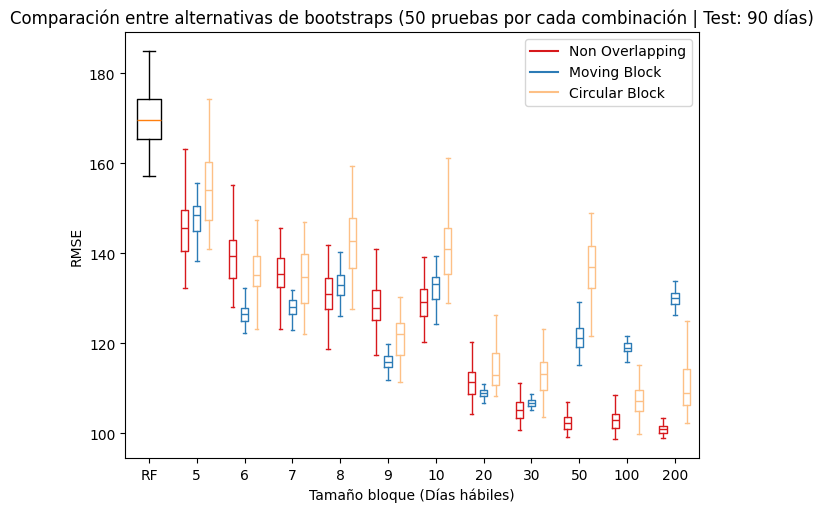

In [18]:
all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping_2y)
all_arr1, ticksIdx, ticksNames = getGraphData(precisionMovingBlock_2y)
all_arr2, ticksIdx, ticksNames = getGraphData(precisionCircularBlock_2y)

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bp0 = plt.boxplot(all_arr, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.boxplot(all_arr1, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.boxplot(all_arr2, positions=np.array(range(len(all_arr1)))*2.0+0.5, sym='', widths=0.3)
bp_1 = plt.boxplot(rf_array_2y, positions=np.array(range(len(rf_array_2y))), sym='', widths=1)
set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bp1, '#2C7BB6')
set_box_color(bp2, '#fdc086')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Non Overlapping')
plt.plot([], c='#2C7BB6', label='Moving Block')
plt.plot([], c='#fdc086', label='Circular Block')
plt.legend()

plt.xticks(range(0, len(ticksNames) * 2, 2), ticksNames)
# plt.xlim(-2, len(ticks)*2)
#plt.ylim(34, 55)
plt.tight_layout()
plt.title("Comparación entre alternativas de bootstraps (50 pruebas por cada combinación | Test: 90 días)")
plt.xlabel("Tamaño bloque (Días hábiles)")
plt.ylabel("RMSE")